In [1]:
# Install required libraries (if needed)
# No specific pip for LR

# Import libraries for LR
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

# Load the data
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Preprocessing (tailored but same as common)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.drop('Date', axis=1, inplace=True)

X = df.drop('RainTomorrow', axis=1)
y = LabelEncoder().fit_transform(df['RainTomorrow'])

categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
binary_cat = ['RainToday']
numerical_cols = [col for col in X.columns if col not in categorical_cols + binary_cat]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('bin', OneHotEncoder(drop='first', sparse_output=False), binary_cat)
    ])

X_processed = preprocessor.fit_transform(X)

feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out()) + list(preprocessor.named_transformers_['bin'].get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

Saving Weather Data Set.csv to Weather Data Set.csv


In [3]:
# Member 1: Logistic Regression code
lr = LogisticRegression(max_iter=1000)
param_grid_lr = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10], 'solver': ['liblinear']}
grid_lr = GridSearchCV(lr, param_grid_lr, cv=StratifiedKFold(n_splits=5), scoring='f1')
grid_lr.fit(X_train, y_train)

print(f'Best Params: {grid_lr.best_params_}')
best_lr = grid_lr.best_estimator_

Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


CV Accuracy: 0.8491 ± 0.0022
Accuracy: 0.8445
F1: 0.5807
Precision: 0.7094
Recall: 0.4916
AUC: 0.8649


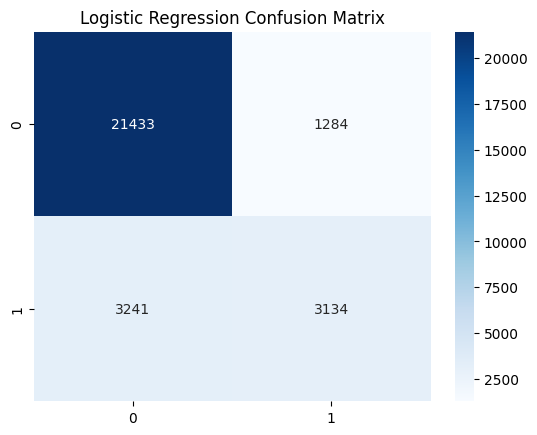

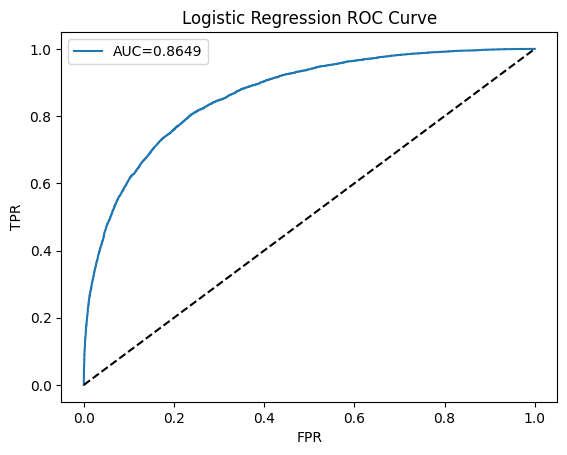

In [4]:

cv_scores = cross_val_score(best_lr, X_train, y_train, cv=5, scoring='accuracy')
print(f'CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

y_pred_lr = best_lr.predict(X_test)
#evaluate model
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}')
print(f'F1: {f1_score(y_test, y_pred_lr):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_lr):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_lr):.4f}')
print(f'AUC: {roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1]):.4f}')

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_lr.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1]):.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('Logistic Regression ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
plt.show()